In [1]:
#from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ, GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

Generate some synthetic concentration data.
We have a source of pollution at [10, 20] at time -4.

In [46]:
def getrealconc(t,x,y,D):
    """For a sythentic dataset, provides the real concentration that will result from the simulated sources
    """
    blobcentre = np.array([t+10,t+20]) #1m/s
    blobsize = np.sqrt(2*2*D*(t+4))
    if blobsize<1: blobsize=1
    d = np.linalg.norm(np.array([x,y])-blobcentre)
    #v = d
    v = 1000*norm(0,blobsize).pdf(d)*norm(10,1).cdf(t)/blobsize #normalised.
    
    return [t,t+10,x,y],v

In [99]:
X = []
Y = []
D = 2
for x in np.linspace(10,90,7):#7):
    for y in np.linspace(10,90,7):#7):
        for t in np.linspace(0,60,7):
            newX,newY = getrealconc(t,x,y,D)
            X.append(newX)
            Y.append(newY)
X = np.array(X)
Y = np.array(Y)
#Y /= np.std(Y)

Plot the concentration over time:

/home/mike/anaconda3/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


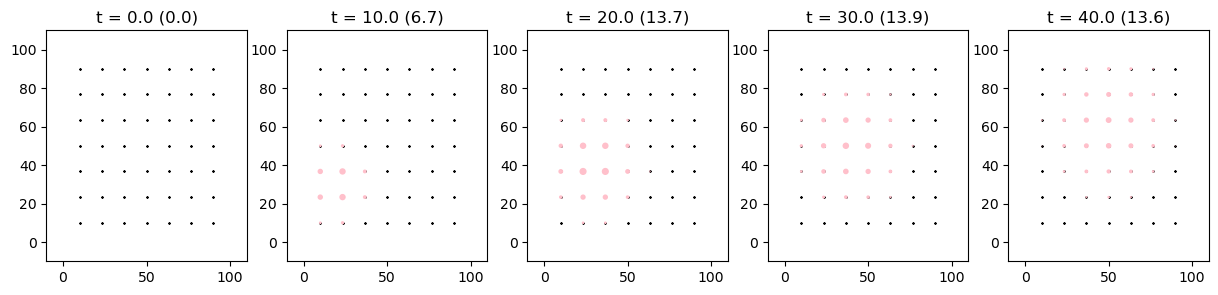

In [100]:
plt.figure(figsize=[15,3])
for i,t in enumerate(np.arange(0,50,10)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')
    plt.title("t = %0.1f (%0.1f)" % (t,np.sum(Y[keep])))
    

In [101]:
boundary = proposeboundary(X) #for our given observation locations pick a boundary that fits them all
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10
#boundary = ([-7.0, -10, -10], [77.0, 100, 100])
print(boundary)

([-7.0, -10, -10], [77.0, 98.0, 98.0])


In [102]:
np.random.seed(42) #random seed fixed at start
#set up our model...
N_feat = 1500 #Number of features used to infer the source
k = EQ(10, 1) #our choice of kernel [EQ kernel, using fourier features]
#k = GaussianBases(25, 1) #<--- This kernel doesn't place features randomly, but on a grid!
res = [120,30,30] #120 time steps...

noiseSD = 0.001 #this is how noisy the measurements are.

sensors = FixedSensorModel(X,3) #this is how our data is observed.

windmodel=WindSimple(1,1) #wind is the same everywhere it heads north east at 1.4m/s

k_0 = 0.5 #diffusion cooef? [doesn't match the simulation!!]

#Initiate new model for inference
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0)

mInfer.computeModelRegressors(Nparticles=20) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix

#simple way
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

#if we want lots of samples from the posterior do this...
Nsamps = 20
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)
print("Actual number of features: %d" % k.N_feat)

Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...


/tmp/ipykernel_5327/179778523.py:28: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)


cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...


In [103]:
sourcemean.shape

(120, 30, 30)

In [104]:
mInfer.getGridCoord([10,0,0])[0]

24

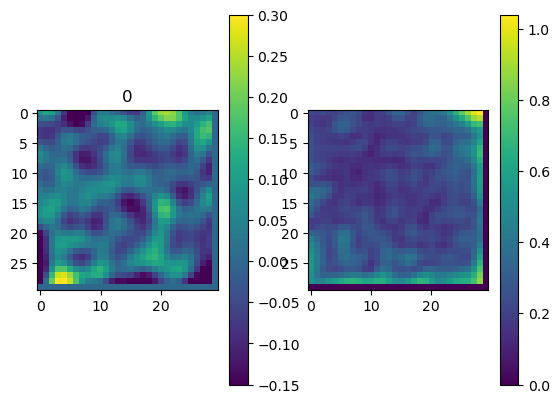

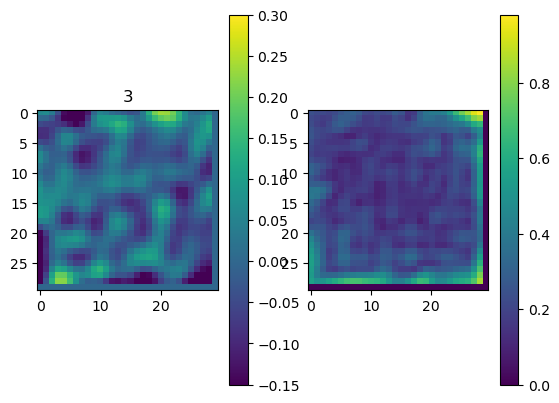

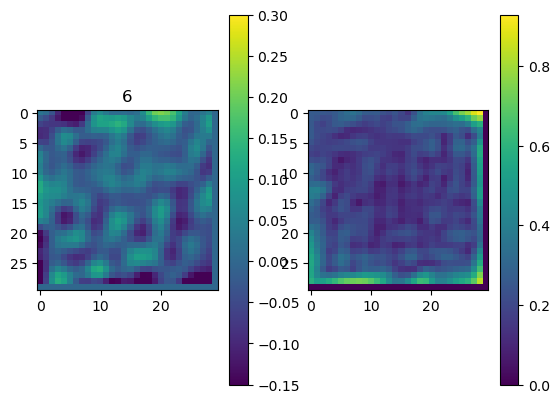

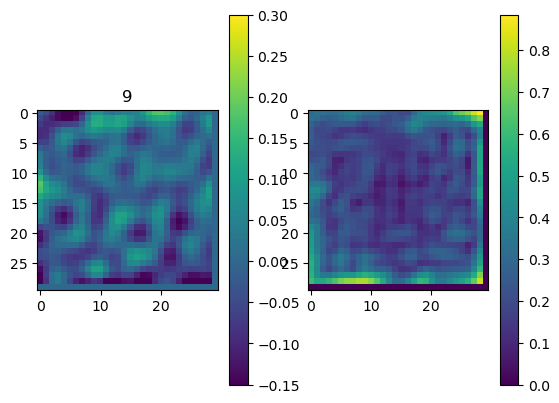

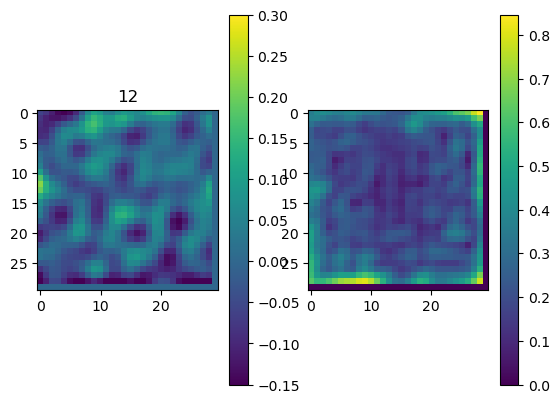

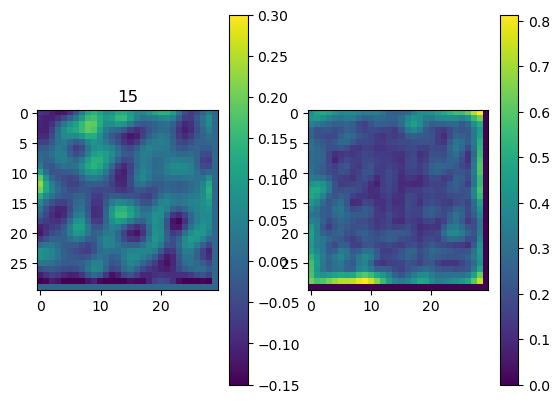

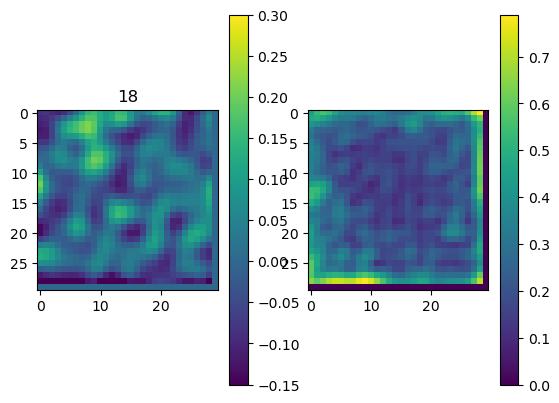

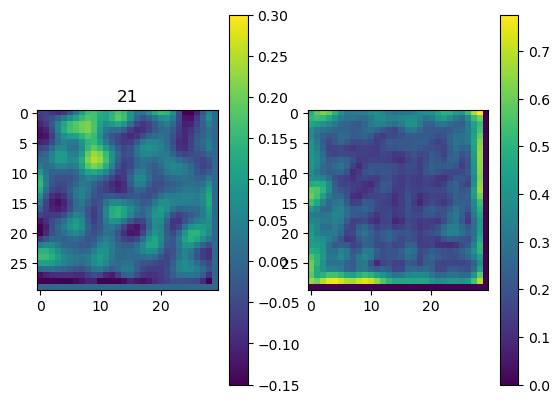

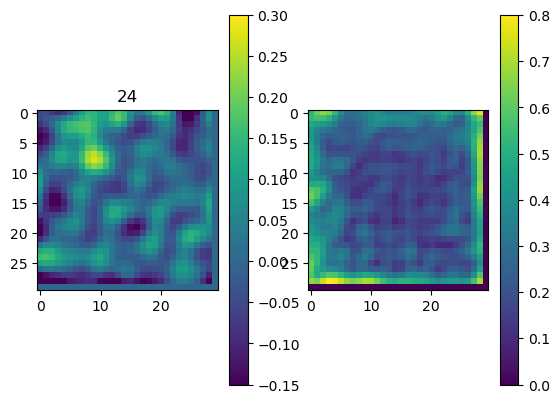

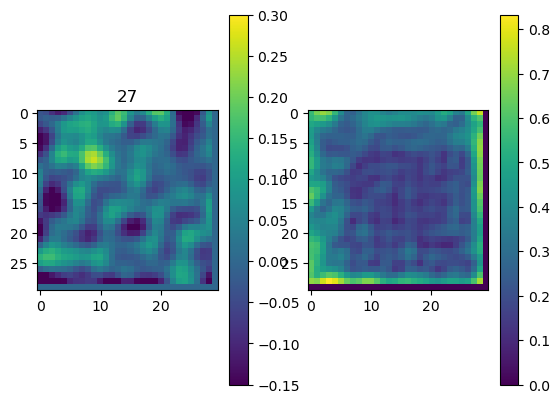

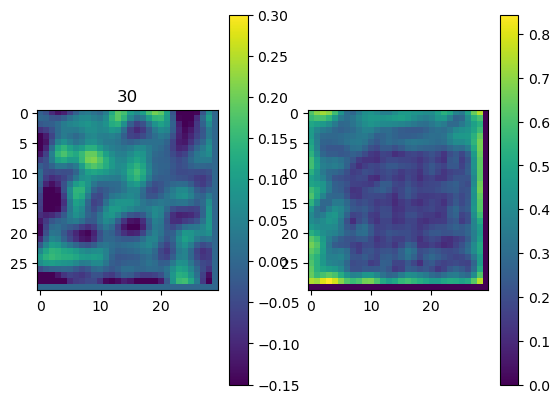

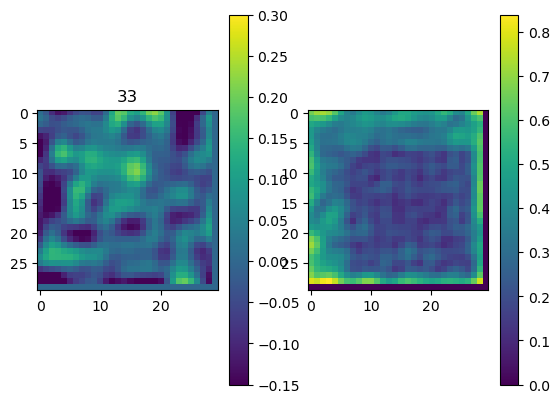

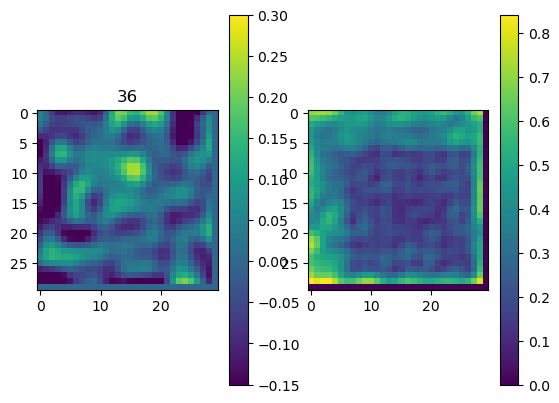

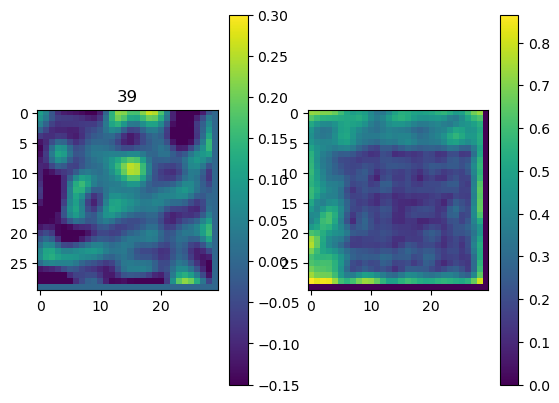

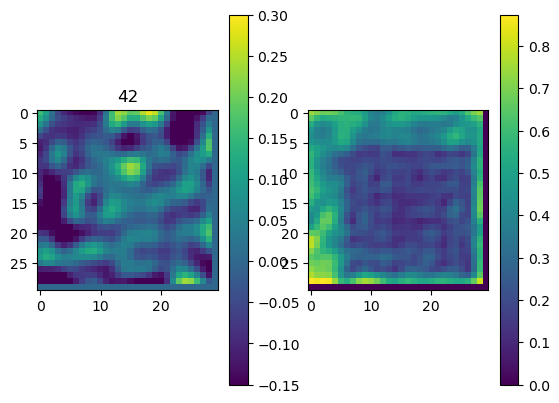

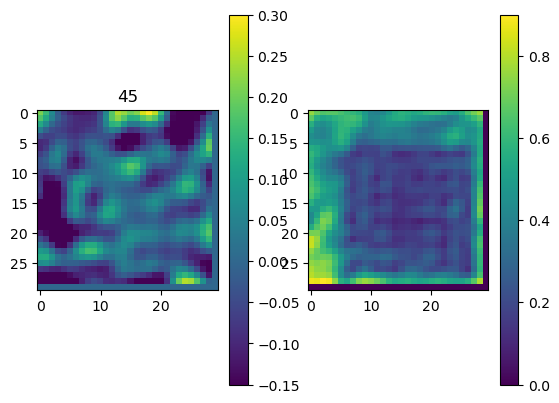

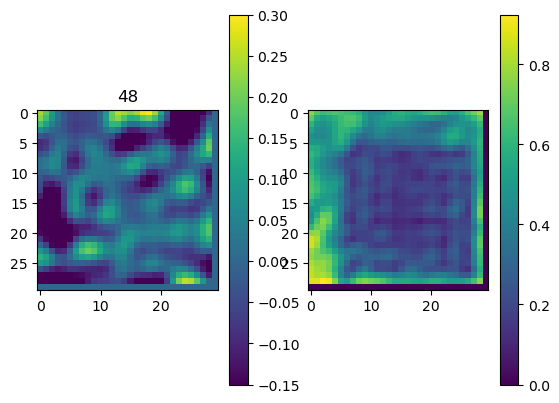

In [105]:
for t_index in range(0,50,3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(t_index)
    plt.imshow(sourcemean[t_index,:,:],clim=[-0.15,0.3])
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(np.sqrt(sourcevar[t_index,:,:]))#,clim=[-0.15,0.3])
    plt.colorbar()

# coding examples for generating particles

In [14]:
exampleparticles = mInfer.genParticlesFromObservations(10)

In [17]:
exampleparticles[:,0,2]

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

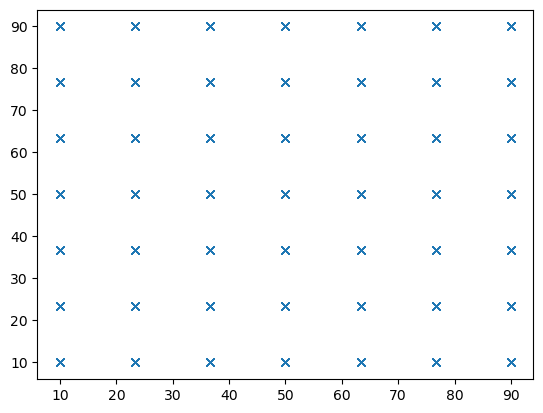

In [19]:
plt.plot(exampleparticles[0,:,1],exampleparticles[0,:,2],'x')

In [22]:
exampleparticles.shape #3430 points going in... each at a given time/space

(10, 343, 3)

In [25]:
trickyparticles = np.random.rand(10,20,18,30,3)

In [27]:
trickyparticles.shape

(10, 20, 18, 30, 3)

In [26]:
mInfer.windmodel.getwind(trickyparticles).shape #3430 vectors out..

(10, 20, 18, 30, 2)

In [10]:
mInfer.kernel.N_feat

500